In [235]:
import sympy as sp
from sympy import Matrix, sin, cos, pi
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import imageio
import math
from math import pi

# Constants
m_T, m_H, m_L = 30, 15, 15  # kg
L_T, L_H = 0.3, 0.4  # m
g = 9.81

def RightFootDownPos(q):
    p_ankleR = Matrix([0, 0])
    p_kneeR = p_ankleR + Matrix([-L_H*sin(q[1] + q[2]), L_H*cos(q[1] + q[2])])
    p_hip = p_kneeR + Matrix([-L_H*sin(q[1]), L_H*cos(q[1])])
    p_kneeL = p_hip + Matrix([L_H*sin(q[3]), -L_H*cos(q[3])])
    p_ankleL = p_kneeL + Matrix([L_H*sin(q[3] + q[4]), -L_H*cos(q[3] + q[4])])
    p_T = p_hip + Matrix([L_T*sin(q[0]), L_T*cos(q[0])])
    return p_ankleR, p_kneeR, p_hip, p_ankleL, p_kneeL, p_T

def LeftFootDownPos(q):
    p_ankleL = Matrix([0, 0])
    p_kneeL = p_ankleL + Matrix([-L_H*sin(q[3] + q[4]), L_H*cos(q[3] + q[4])])
    p_hip = p_kneeL + Matrix([-L_H*sin(q[3]), L_T*cos(q[3])])
    p_kneeR = p_hip + Matrix([L_H*sin(q[1]), -L_H*cos(q[1])])
    p_ankleR = p_kneeR + Matrix([L_H*sin(q[1] + q[2]), -L_H*cos(q[1] + q[2])])
    p_T = p_hip + Matrix([L_T*sin(q[0]), L_T*cos(q[0])])
    return p_ankleR, p_kneeR, p_hip, p_ankleL, p_kneeL, p_T

def RightFootDownVel(q, q_dot):
    v_ankleR = Matrix([0, 0])
    v_kneeR = v_ankleR - Matrix([q_dot[2]*L_H*cos(q[1]+q[2]), q_dot[2]*L_H*sin(q[1]+q[2])])
    v_hip = v_kneeR - Matrix([q_dot[1]*L_H*cos(q[1]), q_dot[1]*L_H*sin(q[1])])
    v_kneeL = v_hip + Matrix([q_dot[3]*L_H*cos(q[3]), q_dot[3]*L_H*sin(q[3])])
    v_ankleL = v_kneeL + Matrix([q_dot[4]*L_H*cos(q[3] + q[4]), q_dot[4]*L_H*sin(q[3] + q[4])])
    v_T = v_hip + Matrix([q_dot[0]*L_T*cos(q[0]), -q_dot[0]*L_T*sin(q[0])])
    return v_ankleR, v_kneeR, v_hip, v_ankleL, v_kneeL, v_T

def LeftFootDownVel(q, q_dot):
    v_ankleL = Matrix([0, 0])
    v_T = Matrix([q_dot[5], q_dot[6]])
    v_hip = v_T - Matrix([q_dot[0]*L_T*cos(q[0]), -q_dot[0]*L_T*sin(q[0])])
    v_kneeR = v_hip + Matrix([q_dot[1]*L_H*cos(q[1]), q_dot[1]*L_H*sin(q[1])])
    v_kneeL = v_hip + Matrix([q_dot[3]*L_H*cos(q[3]), q_dot[3]*L_H*sin(q[3])])
    v_ankleL = v_kneeL + Matrix([q_dot[4]*L_H*cos(q[3] + q[4]), q_dot[4]*L_H*sin(q[3] + q[4])])
    return v_ankleL, v_kneeR, v_hip, v_ankleL, v_kneeL, v_T

def LagrangianRight(q, q_dot):
    p_ankleR, p_kneeR, p_hip, p_ankleL, p_kneeL, p_T = RightFootDownPos(q)
    # Compute symbolic Jacobian J
    J = Matrix([
        [sp.diff(p_hip[0], q_i) for q_i in q],  # Row for p_T[0]
        [sp.diff(p_hip[1], q_i) for q_i in q],  # Row for p_T[1]
        [sp.diff(p_ankleL[0], q_i) for q_i in q],  # Row for p_ankleL[0]
        [sp.diff(p_ankleL[1], q_i) for q_i in q]   # Row for p_ankleL[1]
    ])  # Ensure it's properly shaped as Jacobian

    # Compute symbolic time derivative J_dot
    J_dot = sp.Matrix.zeros(*J.shape)  # Initialize zero matrix

    for i in range(J.shape[0]):  # Loop over rows
        for j in range(J.shape[1]):  # Loop over columns
            # Compute time derivative using chain rule: dJ_ij/dt = sum(dJ_ij/dq_k * dq_k/dt)
            J_dot[i, j] = sum(sp.diff(J[i, j], q_k) * q_dot_k for q_k, q_dot_k in zip(q, q_dot))

    V = (
        p_ankleL[1]*m_L*g + p_ankleR[1]*m_L*g + p_hip[1]*m_H*g +
        p_T[1]*m_T*g + p_kneeR[1]*m_H*g + p_kneeL[1]*m_H*g
    )
    v_ankleR, v_kneeR, v_hip, v_ankleL, v_kneeL, v_T = RightFootDownVel(q, q_dot)
    T = (
        0.5*m_L*(v_ankleL.dot(v_ankleL)) +
        0.5*m_H*(v_kneeR.dot(v_kneeR)) +
        0.5*m_H*(v_kneeL.dot(v_kneeL)) +
        0.5*m_H*(v_hip.dot(v_hip)) +
        0.5*m_T*(v_T.dot(v_T))
    )
    return T - V, J, J_dot

def LagrangianLeft(q, q_dot):
    p_ankleR, p_kneeR, p_hip, p_ankleL, p_kneeL, p_T = LeftFootDownPos(q)
    V = (
        p_ankleL[1]*m_L*g + p_ankleR[1]*m_L*g + p_hip[1]*m_H*g +
        p_T[1]*m_T*g + p_kneeR[1]*m_H*g + p_kneeL[1]*m_H*g
    )
    v_ankleR, v_kneeR, v_hip, v_ankleL, v_kneeL, v_T = LeftFootDownVel(q, q_dot)
    T = (
        0.5*m_L*(v_ankleR.dot(v_ankleR)) +
        0.5*m_H*(v_kneeR.dot(v_kneeR)) +
        0.5*m_H*(v_kneeL.dot(v_kneeL)) +
        0.5*m_H*(v_hip.dot(v_hip)) +
        0.5*m_T*(v_T.dot(v_T))
    )
    return T - V

def compute_lagrange_matrices(q, q_dot, Lagrangian):
    q_ddot = sp.symbols(f'q0_ddot:{len(q)}')  # Second derivatives (accelerations)
    
    # Initialize matrices
    D = sp.zeros(len(q), len(q))  # Mass matrix
    C = sp.zeros(len(q), len(q))  # Coriolis matrix
    G = sp.zeros(len(q), 1)       # Gravity vector

    for i in range(len(q)):
        # Compute derivatives
        dL_dq = sp.diff(Lagrangian, q[i])
        dL_dqdot = sp.diff(Lagrangian, q_dot[i])

        # Compute mass matrix D(q) (coefficients of q_ddot)
        for j in range(len(q)):
            D[i, j] = sp.diff(dL_dqdot, q_dot[j])

        # Compute total time derivative of dL/dq_dot using the chain rule
        d_dt_dL_dqdot = sum(sp.diff(dL_dqdot, q[j]) * q_dot[j] + sp.diff(dL_dqdot, q_dot[j]) * q_ddot[j] for j in range(len(q)))

        # Euler-Lagrange equation: d/dt (∂L/∂q̇) - ∂L/∂q = τ_i
        equation = d_dt_dL_dqdot - dL_dq

        # Extract Coriolis and Centrifugal matrix C(q, q_dot) (terms involving q_dot)
        for j in range(len(q)):
            C[i, j] = sp.simplify(sp.diff(equation, q_dot[j]))

        # Extract Gravity vector G(q) (terms independent of q_dot and q_ddot)
        G[i] = equation.subs({q_dot[j]: 0 for j in range(len(q))}).subs({q_ddot[j]: 0 for j in range(len(q))})

    return D, C, G

def compute_D_numeric(q_vals, D_symbolic):
    q_vars = sp.symbols(f'q0:{len(q_vals)}')  # Define symbolic q variables
    subs_dict = {q_vars[i]: q_vals[i] for i in range(len(q_vals))}  # Create substitution dictionary
    D_numeric = D_symbolic.subs(subs_dict).evalf()  # Substitute and evaluate
    return np.array(D_symbolic.subs(subs_dict).evalf(), dtype=float)

def compute_C_numeric(q_vals, q_dot_vals, C_symbolic):
    q_vars = sp.symbols(f'q0:{len(q_vals)}')  # Define symbolic q variables
    q_dot_vars = sp.symbols(f'q0_dot:{len(q_dot_vals)}')  # Define symbolic q_dot variables
    subs_dict = {q_vars[i]: q_vals[i] for i in range(len(q_vals))}
    subs_dict.update({q_dot_vars[i]: q_dot_vals[i] for i in range(len(q_dot_vals))})
    return np.array(C_symbolic.subs(subs_dict).evalf(), dtype=float)

def compute_G_numeric(q_vals, G_symbolic):
    q_vars = sp.symbols(f'q0:{len(q_vals)}')  # Define symbolic q variables
    subs_dict = {q_vars[i]: q_vals[i] for i in range(len(q_vals))}  # Create substitution dictionary
    return np.array(G_symbolic.subs(subs_dict).evalf(), dtype=float)

def compute_J_numeric(q_vals, J_symbolic):
    q_vars = sp.symbols(f'q0:{len(q_vals)}')  # Define symbolic q variables
    subs_dict = {q_vars[i]: q_vals[i] for i in range(len(q_vals))}  # Create substitution dictionary
    return np.array(J_symbolic.subs(subs_dict).evalf(), dtype=float)

def compute_Jdot_numeric(q_vals, q_dot_vals, J_dot_symbolic):
    q_vars = sp.symbols(f'q0:{len(q_vals)}')  # Generalized coordinates
    q_dot_vars = sp.symbols(f'q0_dot:{len(q_dot_vals)}')  # Generalized velocities
    subs_dict = {q_vars[i]: q_vals[i] for i in range(len(q_vals))}
    subs_dict.update({q_dot_vars[i]: q_dot_vals[i] for i in range(len(q_dot_vals))})  # Add q_dot values
    return np.array(J_dot_symbolic.subs(subs_dict).evalf(), dtype=float)

def compute_vdes_dot(J,D,F):
    return np.linalg.pinv(J @ (np.linalg.pinv(D) @ J.T)) @ F

def compute_q_ddot_des(vdes_dot, J, J_dot, q_dot):
    return np.linalg.pinv(J) @ (vdes_dot - J_dot @ q_dot)

def computeT(q_ddot_des, D, C, G):
    return D @ q_ddot_des + C @ q_ddot_des + G

def compute_q_dotdot(tau, q_dot, D, C, G):
    q_dotdot = np.linalg.inv(D) @ (tau - (C @ q_dot) - G)
    return q_dotdot.reshape(-1)

def Positions(q,x,y):
    p_ankleR = np.array([x, y])
    p_kneeR = p_ankleR + np.array([-L_H*math.sin(q[1] + q[2]), L_H*math.cos(q[1] + q[2])])
    p_hip = p_kneeR + np.array([-L_H*math.sin(q[1]), L_H*math.cos(q[1])])
    p_kneeL = p_hip + np.array([L_H*math.sin(q[3]), -L_H*math.cos(q[3])])
    p_ankleL = p_kneeL + np.array([L_H*math.sin(q[3] + q[4]), -L_H*math.cos(q[3] + q[4])])
    p_T = p_hip + np.array([L_T*math.sin(q[0]), L_T*math.cos(q[0])])
    return p_ankleR, p_kneeR, p_hip, p_ankleL, p_kneeL, p_T

def Velocities(q, q_dot):
    v_ankleR = np.array([0, 0])
    v_kneeR = v_ankleR - np.array([q_dot[2]*L_H*math.cos(q[1]+q[2]), q_dot[2]*L_H*math.sin(q[1]+q[2])])
    v_hip = v_kneeR - np.array([q_dot[1]*L_H*math.cos(q[1]), q_dot[1]*L_H*math.sin(q[1])])
    v_kneeL = v_hip + np.array([q_dot[3]*L_H*math.cos(q[3]), q_dot[3]*L_H*math.sin(q[3])])
    v_ankleL = v_kneeL + np.array([q_dot[4]*L_H*math.cos(q[3] + q[4]), q_dot[4]*L_H*math.sin(q[3] + q[4])])
    v_T = v_hip + np.array([q_dot[0]*L_T*math.cos(q[0]), -q_dot[0]*L_T*math.sin(q[0])])
    return v_ankleR, v_kneeR, v_hip, v_ankleL, v_kneeL, v_T


In [236]:
#Calculating dynamics dependent symbolic martices
q = sp.symbols('q0:5')
q_dot = sp.symbols('q0_dot:5')

L,J,J_dot = LagrangianRight(q, q_dot)
D,C,G = compute_lagrange_matrices(q, q_dot, L)

In [338]:
dt = 0.002  # Time step (s)
t_total = 0.25  # Total simulation time (s)
num_steps = int(t_total / dt)  # Number of time steps

a_torsoStart = pi/12
a_hipStart = pi/18

q = np.array([a_torsoStart, 0.8*a_hipStart, -2*a_hipStart, a_hipStart, -3*a_hipStart])
q_dot = np.array([0, -1, -1.5, 1, 2])
p_ankleR_start, p_kneeR_start, p_hip_start, p_ankleL_start, p_kneeL_start, p_T_start = Positions(q,0,0)
H = p_hip_start[1]

t_values = np.linspace(0, t_total, num_steps)
q_values = np.zeros((len(q), num_steps))
q_dot_values = np.zeros((len(q_dot), num_steps))
T_values = np.zeros((len(q_dot), num_steps))
p_ankleL_values = np.zeros((2, num_steps))
p_ankleR_values = np.zeros((2, num_steps))
p_hip_values = np.zeros((2, num_steps))
p_T_values = np.zeros((2, num_steps))
p_kneeL_values = np.zeros((2, num_steps))
p_kneeR_values = np.zeros((2, num_steps))
VirtualForceT_values = np.zeros((2, num_steps))
VirtualForceA_values = np.zeros((2, num_steps))

v = 1 #m/s
KpTx = 100
KpTy = 50
KdT = 1
KpAx = 10
KpAy = 10
KdA = 1

x_leg = 0
y_leg = 0
for i in range(num_steps):

    s = 0
    dep = 0
    if q_dot[3] > 0.5:
        dep = 3
        s = 1
        KpTx = 100
        KpTy = 100
        KpAx = 10
        KpAy = 10
    else:
        s = 3
        dep = 1
        KpTx = 10
        KpTy = 10
        KpAx = 100
        KpAy = 100

    d = 0.1 #step size distance
    t = t_values[i]  # Current time step
    p_ankleR, p_kneeR, p_hip, p_ankleL, p_kneeL, p_T = Positions(q, x_leg, y_leg)
    p_ankleR_values[:, i] = p_ankleR
    p_ankleL_values[:, i] = p_ankleL
    p_hip_values[:, i] = p_hip
    p_T_values[:, i] = p_T
    p_kneeL_values[:, i] = p_kneeL
    p_kneeR_values[:, i] = p_kneeR

    disT = v*t + 1.2*p_hip_start[0]
    disA = 1.5*v*t + p_ankleL_start[0]

    xDes = 0
    yDes = 0    
    if p_ankleL[0] < p_ankleR[0]:
        yDes = 0.02
        xDes = p_ankleR[0]

    else:
        yDes = 0.01
        xDes = p_hip[0]


    VirtualForceT_values[:, i] = np.array([disT, H])
    VirtualForceA_values[:, i] = np.array([xDes, yDes])

    v_ankleR, v_kneeR, v_hip, v_ankleL, v_kneeL, v_T = Velocities(q, q_dot)
    FpTx = KpTx*(disT - p_hip[0]) - KdT*(0-v_hip[0])
    FpTy = KpTy*(H - p_hip[1]) - KdT*(v_hip[1])
    FpAx = KpAx*(xDes - p_ankleL[0]) - KdA*(0 - v_ankleL[0])
    FpAy = KpAy*(yDes - p_ankleL[1]) - KdA*(0 - v_ankleL[1])
    # Compute system matrices
    D_num = compute_D_numeric(q, D)  # Mass matrix
    C_num = compute_C_numeric(q, q_dot, C) 
    G_num = compute_G_numeric(q, G)
    J_num = compute_J_numeric(q, J)
    J_dot_num = compute_Jdot_numeric(q, q_dot, J_dot)
    vdes_dot = compute_vdes_dot(J_num,D_num,np.array([[FpTx],[FpTy],[FpAx],[FpAy]]))
    q_ddot_des = compute_q_ddot_des(vdes_dot, J_num, J_dot_num, q_dot.reshape(-1,1))
    # q_ddot_des[0] = 0 #Keep torso angle constant
    Tau = computeT(q_ddot_des, D_num, C_num, G_num)
    print(FpTx,FpTy,FpAx,FpAy)

    for k in range(0,len(Tau)):
        if k  == s:
            continue
        elif Tau[k] > 150.0:
            Tau[k] = 150.0
        elif Tau[k] < -150.0:
            Tau[k] = -150.0
    
    Tau[s] = Tau[0] - Tau[dep]

    # Compute q_dotdot
    q_dotdot = compute_q_dotdot(Tau, q_dot.reshape(-1,1), D_num, C_num, G_num)

    # Euler integration to update q_dot and q
    q_dot += q_dotdot * dt
    q += q_dot * dt

    if q[2] > 0:
        q[2] = 0
    if q[4] > 0:
        q[4] = 0
    # Store results
    q_values[:, i] = q
    q_dot_values[:, i] = q_dot
    T_values[:,i] = Tau.reshape(-1)

    #state switching
    if (p_ankleL[1] < 0.0):
        q_old = q
        q_dotold = q_dot
        q = np.array([q_old[0], q_old[3], q_old[4], q_old[1], q_old[2]])
        q_dot = np.array([q_dotold[0], q_dotold[3], q_dotold[4], q_dotold[1], q_dotold[2]])
        x_leg = p_ankleL[0]
        y_leg = p_ankleL[1]

# Print final results


1.5329045067984621 0.06907777410662942 2.5272064889747 -0.24889580040943093
1.4879570095930528 0.06986851963404679 2.4967721301921535 -0.2179662785171395
1.3944440326615262 0.07514040123707838 2.462195366568153 -0.18689385751610935
1.2355418186776606 0.09045937872174586 2.4361653337157216 -0.16383285111014628
1.029121862842818 0.11487594659428013 2.4266018459625007 -0.1524325304183628
0.8241244326370637 0.14179781621953716 2.4152784349781022 -0.13884995634318903
0.6658678793944429 0.16101228316241156 2.40217837822272 -0.12397837917862722
0.4999501628400259 0.18367666782868763 2.891824394110688 -0.20666975442831148
0.4010163399661103 0.19319003408879407 2.904682696943968 -0.18952323402482135
0.24367134663338075 0.2151236517784368 2.9132020726228824 -0.168409359747269
0.15563549423621614 0.22450713298595892 2.919842321583166 -0.14761744455106482
0.027231503745362318 0.24254288380877392 2.9223836307136475 -0.12262824013674473
0.0032257041090608674 0.24020545865146195 2.925056705448396 -0.

Final q values: [-1.14247198  0.23427742  0.         -0.7113581  -2.12949418]
Final q_dot values: [ -4.00693849   1.76536445   8.15134596 -10.67350772 -22.78223661]


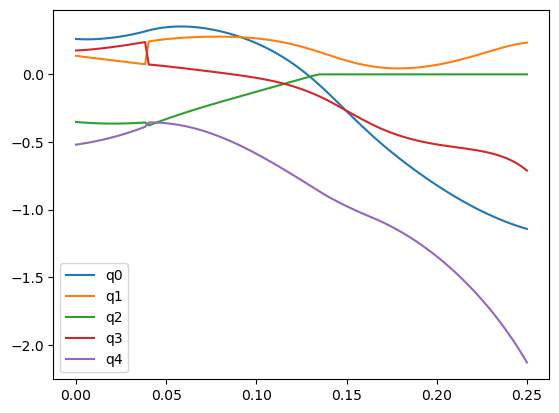

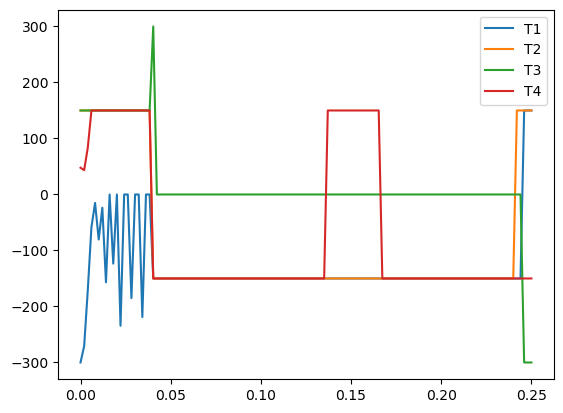

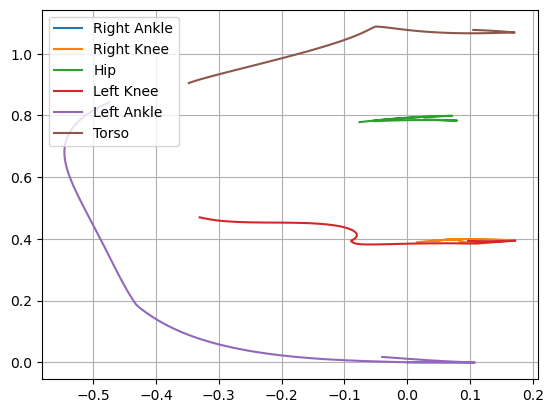

In [339]:
print("Final q values:", q_values[:, -1])
print("Final q_dot values:", q_dot_values[:, -1])
plt.figure()
plt.plot(t_values, q_values[0, :], label='q0')
plt.plot(t_values, q_values[1, :], label='q1')
plt.plot(t_values, q_values[2, :], label='q2')
plt.plot(t_values, q_values[3, :], label='q3')
plt.plot(t_values, q_values[4, :], label='q4')
plt.legend()

plt.figure()
plt.plot(t_values, T_values[1, :], label='T1')
plt.plot(t_values, T_values[2, :], label='T2')
plt.plot(t_values, T_values[3, :], label='T3')
plt.plot(t_values, T_values[4, :], label='T4')
plt.legend()

plt.figure()
plt.plot(p_ankleR_values[0, :], p_ankleR_values[1, :], label='Right Ankle')
plt.plot(p_kneeR_values[0, :], p_kneeR_values[1, :], label='Right Knee')
plt.plot(p_hip_values[0, :], p_hip_values[1, :], label='Hip')
plt.plot(p_kneeL_values[0, :], p_kneeL_values[1, :], label='Left Knee')
plt.plot(p_ankleL_values[0, :], p_ankleL_values[1, :], label='Left Ankle')
plt.plot(p_T_values[0, :], p_T_values[1, :], label='Torso')
plt.grid()
plt.legend()

In [340]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def animate_biped_gif(t_values, p_hip_values, p_T_values, p_kneeL_values, p_kneeR_values, 
                      p_ankleL_values, p_ankleR_values, VirtualForceT_values, VirtualForceA_values, filename='biped_animation.gif'):
    """
    Create and save a GIF animation of a biped model showing joint positions and connections.
    
    Parameters:
    -----------
    t_values: array-like - Time values
    p_hip_values, p_T_values, p_kneeL_values, p_kneeR_values, p_ankleL_values, p_ankleR_values: 
        Arrays of shape (2, num_steps) containing [x,y] positions at each timestep
    filename: str - Output filename (default: 'biped_animation.gif')
    """
    # Setup figure
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Determine axis limits from all position data
    all_x = np.concatenate([p_hip_values[0], p_T_values[0], p_kneeL_values[0], 
                           p_kneeR_values[0], p_ankleL_values[0], p_ankleR_values[0]])
    all_y = np.concatenate([p_hip_values[1], p_T_values[1], p_kneeL_values[1], 
                           p_kneeR_values[1], p_ankleL_values[1], p_ankleR_values[1]])
    margin = 0.2
    ax.set_xlim(np.min(all_y) - margin, np.max(all_y) + margin)
    ax.set_ylim(np.min(all_y) - margin, np.max(all_y) + margin)
    
    # Initialize plot elements
    points = {}
    points['hip'], = ax.plot([], [], 'bo', ms=8)
    points['torso'], = ax.plot([], [], 'go', ms=10)
    points['kneeL'], = ax.plot([], [], 'co', ms=6)
    points['kneeR'], = ax.plot([], [], 'mo', ms=6)
    points['ankleL'], = ax.plot([], [], 'ro', ms=6)
    points['ankleR'], = ax.plot([], [], 'yo', ms=6)
    points['virtualT'], = ax.plot([], [], 'b*', ms=10, label='Virtual Force Point Hip')
    points['virtualA'], = ax.plot([], [], 'r*', ms=10, label='Virtual Force Point Ankle')


    
    # Initialize lines
    lines = {}
    lines['hip_torso'], = ax.plot([], [], 'k--', lw=1)
    lines['hip_kneeL'], = ax.plot([], [], 'k--', lw=1)
    lines['hip_kneeR'], = ax.plot([], [], 'k--', lw=1)
    lines['kneeL_ankleL'], = ax.plot([], [], 'k--', lw=1)
    lines['kneeR_ankleR'], = ax.plot([], [], 'k--', lw=1)
    
    # Time text
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    
    # Setup
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('Biped Model Animation')
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right')
    
    def update(frame):
        # Update points


        
        # Update lines
        lines['hip_torso'].set_data([p_hip_values[0, frame], p_T_values[0, frame]], 
                                   [p_hip_values[1, frame], p_T_values[1, frame]])
        lines['hip_kneeL'].set_data([p_hip_values[0, frame], p_kneeL_values[0, frame]], 
                                   [p_hip_values[1, frame], p_kneeL_values[1, frame]])
        lines['hip_kneeR'].set_data([p_hip_values[0, frame], p_kneeR_values[0, frame]], 
                                   [p_hip_values[1, frame], p_kneeR_values[1, frame]])
        lines['kneeL_ankleL'].set_data([p_kneeL_values[0, frame], p_ankleL_values[0, frame]], 
                                      [p_kneeL_values[1, frame], p_ankleL_values[1, frame]])
        lines['kneeR_ankleR'].set_data([p_kneeR_values[0, frame], p_ankleR_values[0, frame]], 
                                      [p_kneeR_values[1, frame], p_ankleR_values[1, frame]])
        
        points['hip'].set_data(p_hip_values[0, frame], p_hip_values[1, frame])
        points['torso'].set_data(p_T_values[0, frame], p_T_values[1, frame])
        points['kneeL'].set_data(p_kneeL_values[0, frame], p_kneeL_values[1, frame])
        points['kneeR'].set_data(p_kneeR_values[0, frame], p_kneeR_values[1, frame])
        points['ankleL'].set_data(p_ankleL_values[0, frame], p_ankleL_values[1, frame])
        points['ankleR'].set_data(p_ankleR_values[0, frame], p_ankleR_values[1, frame])
        points['virtualT'].set_data(VirtualForceT_values[0, frame], VirtualForceT_values[1, frame])
        points['virtualA'].set_data(VirtualForceA_values[0, frame], VirtualForceA_values[1, frame])
        # Update time text
        time_text.set_text(f'Time: {t_values[frame]:.2f} s')
        
        return list(points.values()) + list(lines.values()) + [time_text]
    
    # Create and save animation
    ani = FuncAnimation(fig, update, frames=range(len(t_values)), 
                        blit=True, interval=1000/30)
    
    # Save as GIF
    ani.save(filename, writer='pillow', fps=30, dpi=100)
    plt.close(fig)
    
    print(f"Animation saved as '{filename}'")
    return filename

ani = animate_biped_gif(t_values, p_hip_values, p_T_values, p_kneeL_values, p_kneeR_values, 
                    p_ankleL_values, p_ankleR_values, VirtualForceT_values, VirtualForceA_values)

/var/folders/xx/btbwbkqx7rqg46bymdht3p6h0000gn/T/ipykernel_74467/1902120484.py:76: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  points['hip'].set_data(p_hip_values[0, frame], p_hip_values[1, frame])
/var/folders/xx/btbwbkqx7rqg46bymdht3p6h0000gn/T/ipykernel_74467/1902120484.py:77: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  points['torso'].set_data(p_T_values[0, frame], p_T_values[1, frame])
/var/folders/xx/btbwbkqx7rqg46bymdht3p6h0000gn/T/ipykernel_74467/1902120484.py:78: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  points['kneeL'].set_data(p_kneeL_values[0, frame], p_kneeL_values[1, frame])
/var/folders/xx/btbwbkqx7rqg46bymdht3p6h0000gn/T/ipykernel_74467/1902120484.py:79: MatplotlibDeprecationWarning: Setting

Animation saved as 'biped_animation.gif'
